### Installing dependencies

In [20]:
"""
Install required packages using pip.

Packages:
- pandas
- seaborn
- matplotlib
- scikit-learn
- numpy
- openpyxl
- pipenv

Usage: %pip install pandas seaborn matplotlib scikit-learn numpy openpyxl pipenv
"""
%pip install pandas seaborn matplotlib scikit-learn numpy openpyxl pipenv

You should consider upgrading via the 'c:\Users\wesle\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


### Importing the necessary libraries for the workflow.

In [21]:
"""
Installed packages are loaded using the import statement. The # type: ignore comment is used to suppress warnings.
"""
import pandas as pd # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.decomposition import PCA # type: ignore
from sklearn.experimental import enable_iterative_imputer  # type: ignore
from sklearn.impute import IterativeImputer  # type: ignore

### Loading data

In [22]:
"""
Load data from an Excel file and extract specific features.
"""
print("Loading data...")
data = pd.read_excel("data/01. Master_Latest data_Control clones_LP.xlsx", engine='openpyxl')
#data_extracted_features = pd.read_excel("data/01. Master_Latest data_Control clones_LP.xlsx", usecols=['Batch number', 'Genotype Neuron', 'Div calculated', 'Culture treatment', 'Capacitance', 'Input Resistance', 'Resting membrane potential ', 'Maximum firing ', 'Calculated input resistance', 'Rheobase', 'EPSC freq'])
data_extracted_features = pd.read_excel("data/01. Master_Latest data_Control clones_LP.xlsx", usecols=['Batch number', 'Genotype Neuron', 'Div calculated', 'Culture treatment', 'Capacitance', 'Input Resistance', 'Resting membrane potential ', 'Maximum firing ', 'Rheobase', 'EPSC freq'])

print("\n")
print(data_extracted_features)

Loading data...


     Batch number Genotype Neuron  Div calculated   Culture treatment  \
0               1         TSC12.3              33                none   
1               1         TSC12.3              33                none   
2               1         TSC12.3              33                none   
3               1         TSC12.3              33                none   
4               1         TSC12.3              33                none   
..            ...             ...             ...                 ...   
683             3             WTC              58                none   
684             3             WTC              58  microglia 6 weekes   
685             3             WTC              58                none   
686             3             WTC              58                none   
687             3             WTC              58  microglia 6 weekes   

     Capacitance  Input Resistance  Resting membrane potential   \
0           54.0            2100.0    

### Preprocessing data

### Violin plot before preprocessing

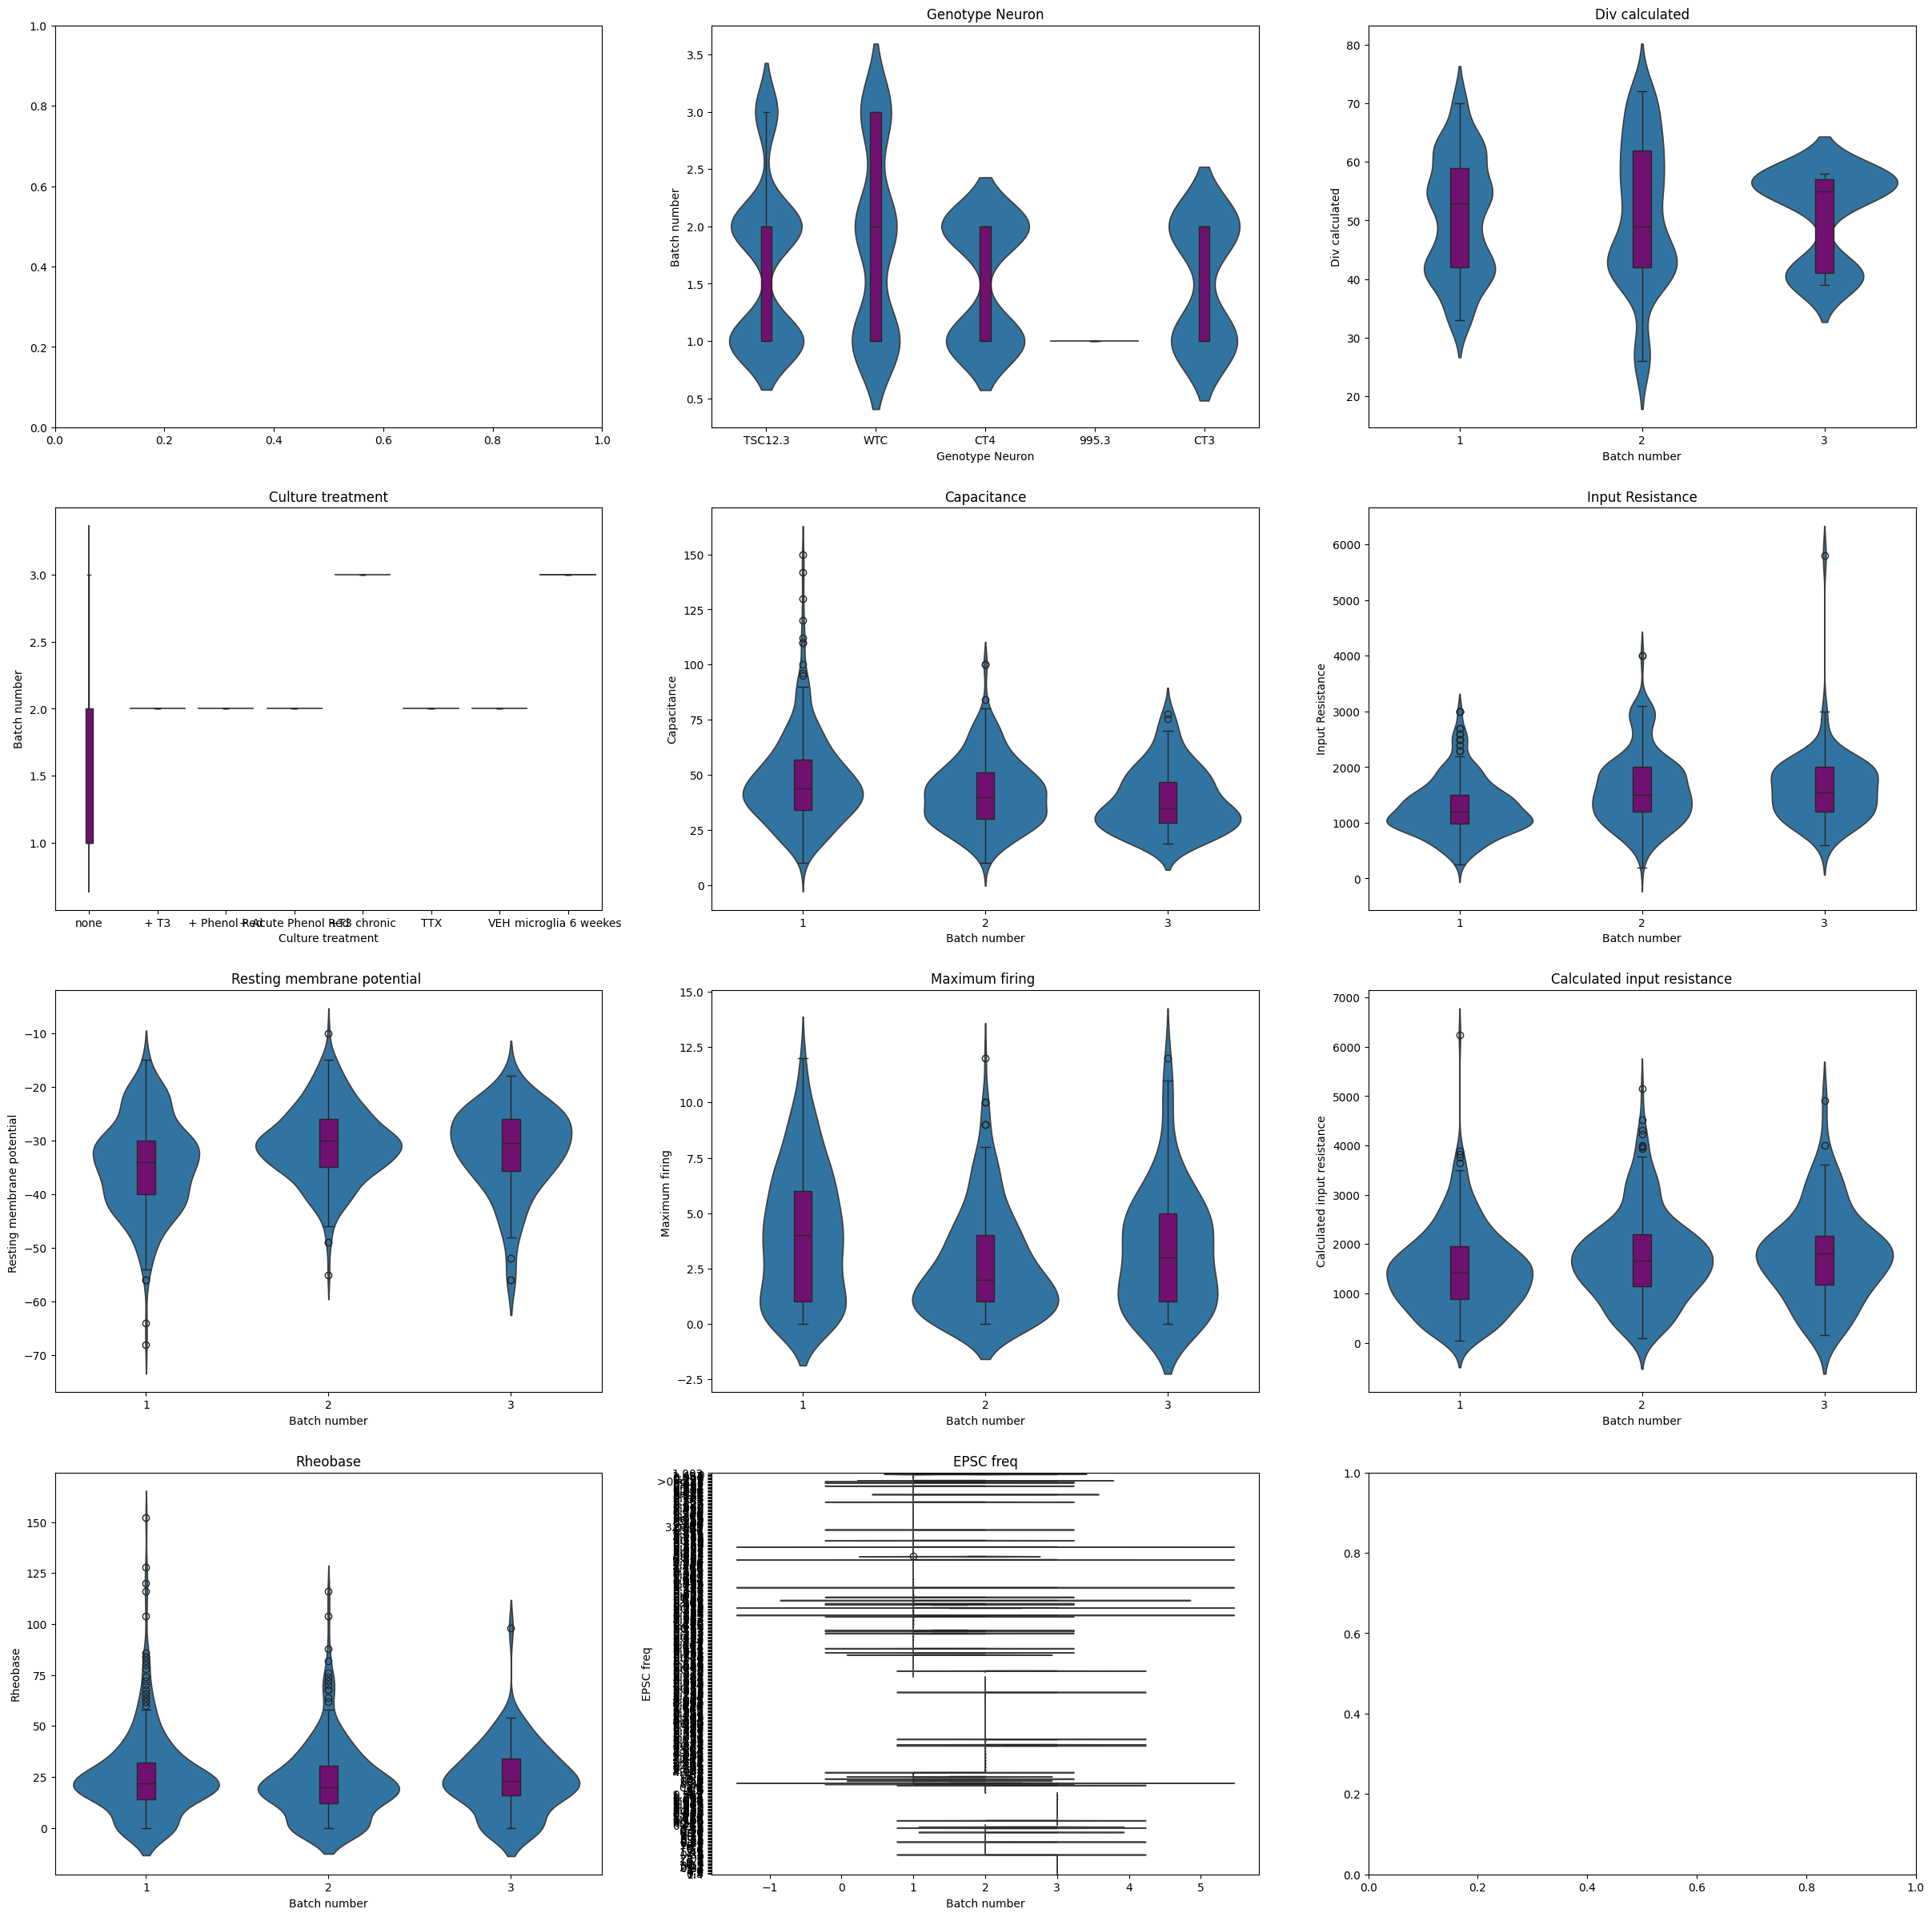

In [80]:
"""
Plots violin and box plots for each feature in the given DataFrame.
"""

# Create a copy of the DataFrame
data_extracted_features_violin_pre = data_extracted_features.copy()

# Create subplots
fig, axes = plt.subplots(4, 3, figsize=(30, 30))
axes = axes.flatten()

# Iterate over each feature in the DataFrame
for i, feature in enumerate(data_extracted_features_violin_pre.columns): 
    if feature == 'Batch number':
        i-=1
        continue
    elif feature == 'Genotype Neuron':
        # Plot violin and box plots for 'Genotype Neuron'
        sns.violinplot(x=feature, y='Batch number', data=data_extracted_features_violin_pre, ax=axes[i], inner=None)
        sns.boxplot(x=feature, y='Batch number', data=data_extracted_features_violin_pre, ax=axes[i], width=0.1, color="purple", meanline=True)
        axes[i].set_title(feature)
    elif feature == 'Culture treatment':
        # Plot violin and box plots for 'Culture treatment'
        sns.violinplot(x=feature, y='Batch number', data=data_extracted_features_violin_pre, ax=axes[i], inner=None)
        sns.boxplot(x=feature, y='Batch number', data=data_extracted_features_violin_pre, ax=axes[i], width=0.1, color="purple", meanline=True)
        axes[i].set_title(feature)
    else:
        # Plot violin and box plots for other features
        sns.violinplot(x='Batch number', y=feature, data=data_extracted_features_violin_pre, ax=axes[i], inner=None)
        sns.boxplot(x='Batch number', y=feature, data=data_extracted_features_violin_pre, ax=axes[i], width=0.1, color="purple", meanline=True)
        axes[i].set_title(feature)


# sns.violinplot(data=data_extracted_features_violin_pre, inner=None)

# for feature in data_extracted_features_violin_pre.columns:
#     sns.violinplot(data=data_extracted_features_violin_pre[feature], inner=None)

# Adjust the layout and display the plot
#plt.tight_layout()
plt.show()


### MICE imputation

In [56]:
"""
Imputes missing values in the given DataFrame using the IterativeImputer algorithm.
"""

#Create copy of the DataFrame
data_extracted_features_impute = data_extracted_features.copy() 

# Initialize the IterativeImputer
imputer = IterativeImputer(random_state=0, sample_posterior=True)
# min_value uiteindleijk op 0
# tol (tolerance) uitgelegd vanuit algoritme/paper 
# sample_posterior uitgelegd vanuit algoritme/paper`
# max iter hoger (100, 1000), kijk naar verschil imputatie waardes 
# 

# Replace '>' values with NaN in 'EPSC freq' column
mask = data_extracted_features_impute['EPSC freq'].notna() & data_extracted_features_impute['EPSC freq'].str.contains(">")
data_extracted_features_impute.loc[mask, 'EPSC freq'] = np.nan

# Convert 'EPSC freq' column to numeric
data_extracted_features_impute['EPSC freq'] = pd.to_numeric(data_extracted_features_impute['EPSC freq'])

# Drop object columns for imputation. The columns which contain categorical values will be dropped for the MICE imputation to work.
# These columns will be added back after imputation.
object_columns = data_extracted_features_impute.select_dtypes(include=['object']).columns
data_extracted_features_impute_copy = data_extracted_features_impute.drop(columns=object_columns)

# Impute missing values
data_extracted_features_imputed = imputer.fit_transform(data_extracted_features_impute_copy)
data_extracted_features_imputed = pd.DataFrame(data_extracted_features_imputed, columns=data_extracted_features_impute_copy.columns)

# Add back the object columns
for column in object_columns:
    data_extracted_features_imputed[column] = data_extracted_features_impute[column]

# Print imputed values for each column
for column in data_extracted_features_impute.columns:
    missing_mask_column = data_extracted_features_impute[column].isnull()
    imputed_missing_mask_column = data_extracted_features_imputed[column].isnull()
    imputed_values_mask_column = (missing_mask_column) & (~imputed_missing_mask_column)
    imputed_values_column = data_extracted_features_impute.loc[imputed_values_mask_column, column]
    imputed_value = data_extracted_features_imputed.loc[imputed_values_mask_column, column]
    if not imputed_values_column.empty:
        imputed_value_pairs = [(original, imputed) for original, imputed in zip(imputed_values_column, imputed_value)]
        print(f"Imputed values for {column}:")
        formatted_output = "\n".join([f"Index: {index + 2}\nOriginal Value: {original} --> Imputed value: {imputed}" for index, (original, imputed) in zip(imputed_values_column.index, imputed_value_pairs)])
        print(formatted_output + "\n")
        # Change negative frequencies to 0
        #data_extracted_features_imputed["EPSC freq"].loc[data_extracted_features_imputed["EPSC freq"] < 0] = 0


Imputed values for Input Resistance:
Index: 651
Original Value: nan --> Imputed value: 1430.974153461512

Imputed values for Maximum firing :
Index: 632
Original Value: nan --> Imputed value: -1.3811830936989251
Index: 637
Original Value: nan --> Imputed value: 4.59127330964675

Imputed values for Calculated input resistance:
Index: 5
Original Value: nan --> Imputed value: 1161.2817216057028
Index: 8
Original Value: nan --> Imputed value: 2353.843425276093
Index: 11
Original Value: nan --> Imputed value: 2594.8362319460257
Index: 21
Original Value: nan --> Imputed value: 440.27805266689825
Index: 22
Original Value: nan --> Imputed value: 2423.5966259481274
Index: 31
Original Value: nan --> Imputed value: 1939.5279817602036
Index: 65
Original Value: nan --> Imputed value: 969.829398024829
Index: 66
Original Value: nan --> Imputed value: 492.3719242059999
Index: 67
Original Value: nan --> Imputed value: 1848.9076674213993
Index: 78
Original Value: nan --> Imputed value: 1130.026121884655

### Violin plot after preprocessing

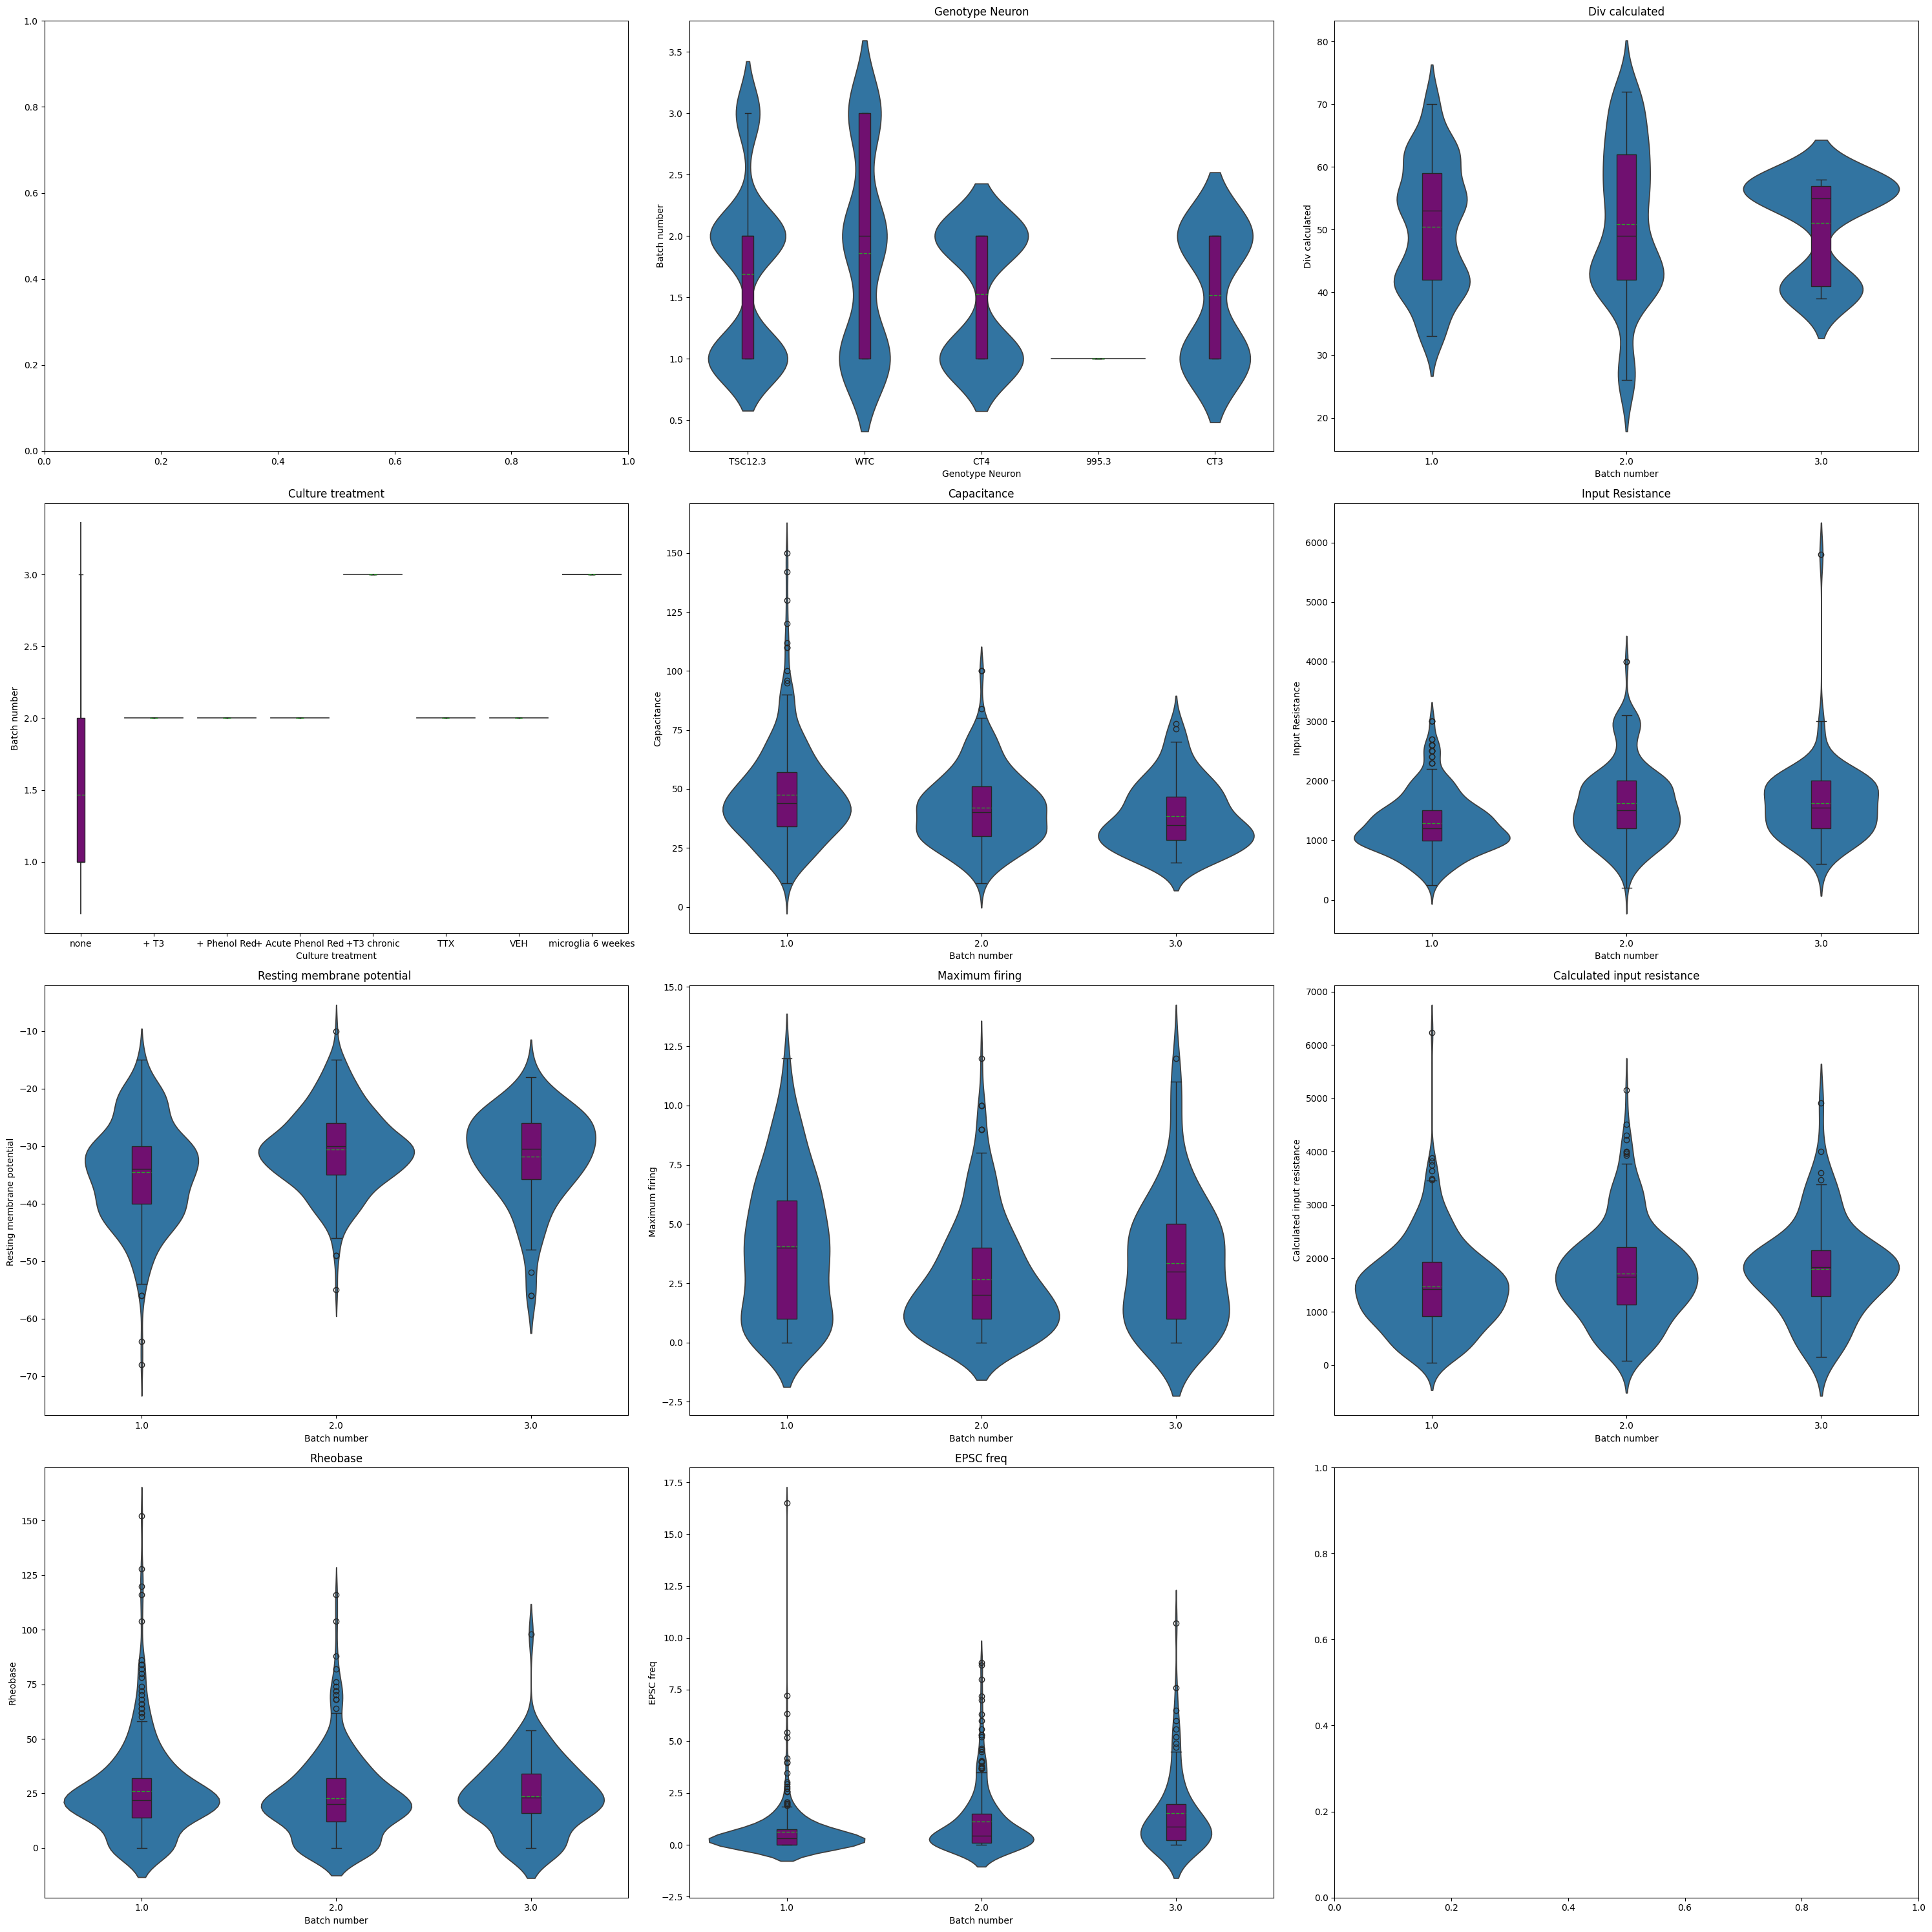

In [25]:

"""
Plots violin and box plots for each feature against the 'Batch number' column.
"""

# Create subplots
fig, axes = plt.subplots(4, 3, figsize=(30, 30))
axes = axes.flatten()

# Iterate over each feature in the DataFrame
for i, feature in enumerate(data_extracted_features_violin_pre.columns):
    if feature == 'Batch number':
        i-=1
        continue
    elif feature == 'Genotype Neuron':
        # Plot violin and box plots for 'Genotype Neuron'
        sns.violinplot(x=feature, y='Batch number', data=data_extracted_features_imputed, ax=axes[i], inner=None)
        sns.boxplot(x=feature, y='Batch number', data=data_extracted_features_imputed, ax=axes[i], width=0.1, color="purple", showmeans=True, meanline=True)
        axes[i].set_title(feature)
    elif feature == 'Culture treatment':
        # Plot violin and box plots for 'Culture treatment'    
        sns.violinplot(x=feature, y='Batch number', data=data_extracted_features_imputed, ax=axes[i], inner=None)
        sns.boxplot(x=feature, y='Batch number', data=data_extracted_features_imputed, ax=axes[i], width=0.1, color="purple", showmeans=True, meanline=True)
        axes[i].set_title(feature)  
    else:
        # Plot violin and box plots for other features  
        sns.violinplot(x='Batch number', y=feature, data=data_extracted_features_imputed, ax=axes[i], inner=None)
        sns.boxplot(x='Batch number', y=feature, data=data_extracted_features_imputed, ax=axes[i], width=0.1, color="purple", showmeans=True, meanline=True)
        axes[i].set_title(feature)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


## GLM imputation

In [26]:
# from sklearn.linear_model import LinearRegression

# data_extracted_features_impute_glm = data_extracted_features.copy()

# imputer_glm = IterativeImputer(estimator=LinearRegression())

# mask_glm = data_extracted_features_impute_glm['EPSC freq'].notna() & data_extracted_features_impute_glm['EPSC freq'].str.contains(">")
# data_extracted_features_impute_glm.loc[mask_glm, 'EPSC freq'] = np.nan

# data_extracted_features_impute_glm['EPSC freq'] = pd.to_numeric(data_extracted_features_impute_glm['EPSC freq'])

# # Drop object columns for imputation. The columns which contain categorical values will be dropped for the MICE imputation to work.
# # These columns will be added back after imputation.
# object_columns_glm = data_extracted_features_impute_glm.select_dtypes(include=['object']).columns
# data_extracted_features_impute_glm_copy = data_extracted_features_impute_glm.drop(columns=object_columns_glm)

# # Fit the imputer to your data
# data_extracted_features_imputed_glm = imputer_glm.fit(data_extracted_features_impute_glm_copy)

# # Impute missing values
# data_extracted_features_imputed_glm = imputer_glm.transform(data_extracted_features_impute_glm_copy)
# data_extracted_features_imputed_glm = pd.DataFrame(data_extracted_features_imputed_glm, columns=data_extracted_features_impute_glm_copy.columns)


# # Add back the object columns
# for column in object_columns_glm: 
#     data_extracted_features_imputed_glm[column] = data_extracted_features_impute_glm[column]

# # data_extracted_features_impute_glm.to_excel("Output.xlsx")

# # Print imputed values for each column
# for column_glm in data_extracted_features.columns:
#     missing_mask_column_glm = data_extracted_features_imputed_glm[column_glm].isnull()
#     imputed_missing_mask_column_glm = data_extracted_features_imputed_glm[column_glm].isnull()
#     imputed_values_mask_column_glm = (missing_mask_column_glm) & (~imputed_missing_mask_column_glm)
#     imputed_values_column_glm = data_extracted_features_impute_glm.loc[imputed_values_mask_column_glm, column_glm]
#     imputed_value_glm = data_extracted_features_imputed_glm.loc[imputed_values_mask_column_glm, column_glm]
#     if not imputed_values_column_glm.empty:
#         imputed_value_pairs_glm = [(original_glm, imputed_glm) for original_glm, imputed_glm in zip(imputed_values_column_glm, imputed_value_glm)]
#         print(f"Imputed values for {column_glm}:")
#         formatted_output = "\n".join([f"Index: {index_glm + 2}\nOriginal Value: {original_glm} --> Imputed value: {imputed_glm}" for index_glm, (original_glm, imputed_glm) in zip(imputed_values_column_glm.index, imputed_value_pairs_glm)])
#         print(formatted_output + "\n")

## Unsupervised learning

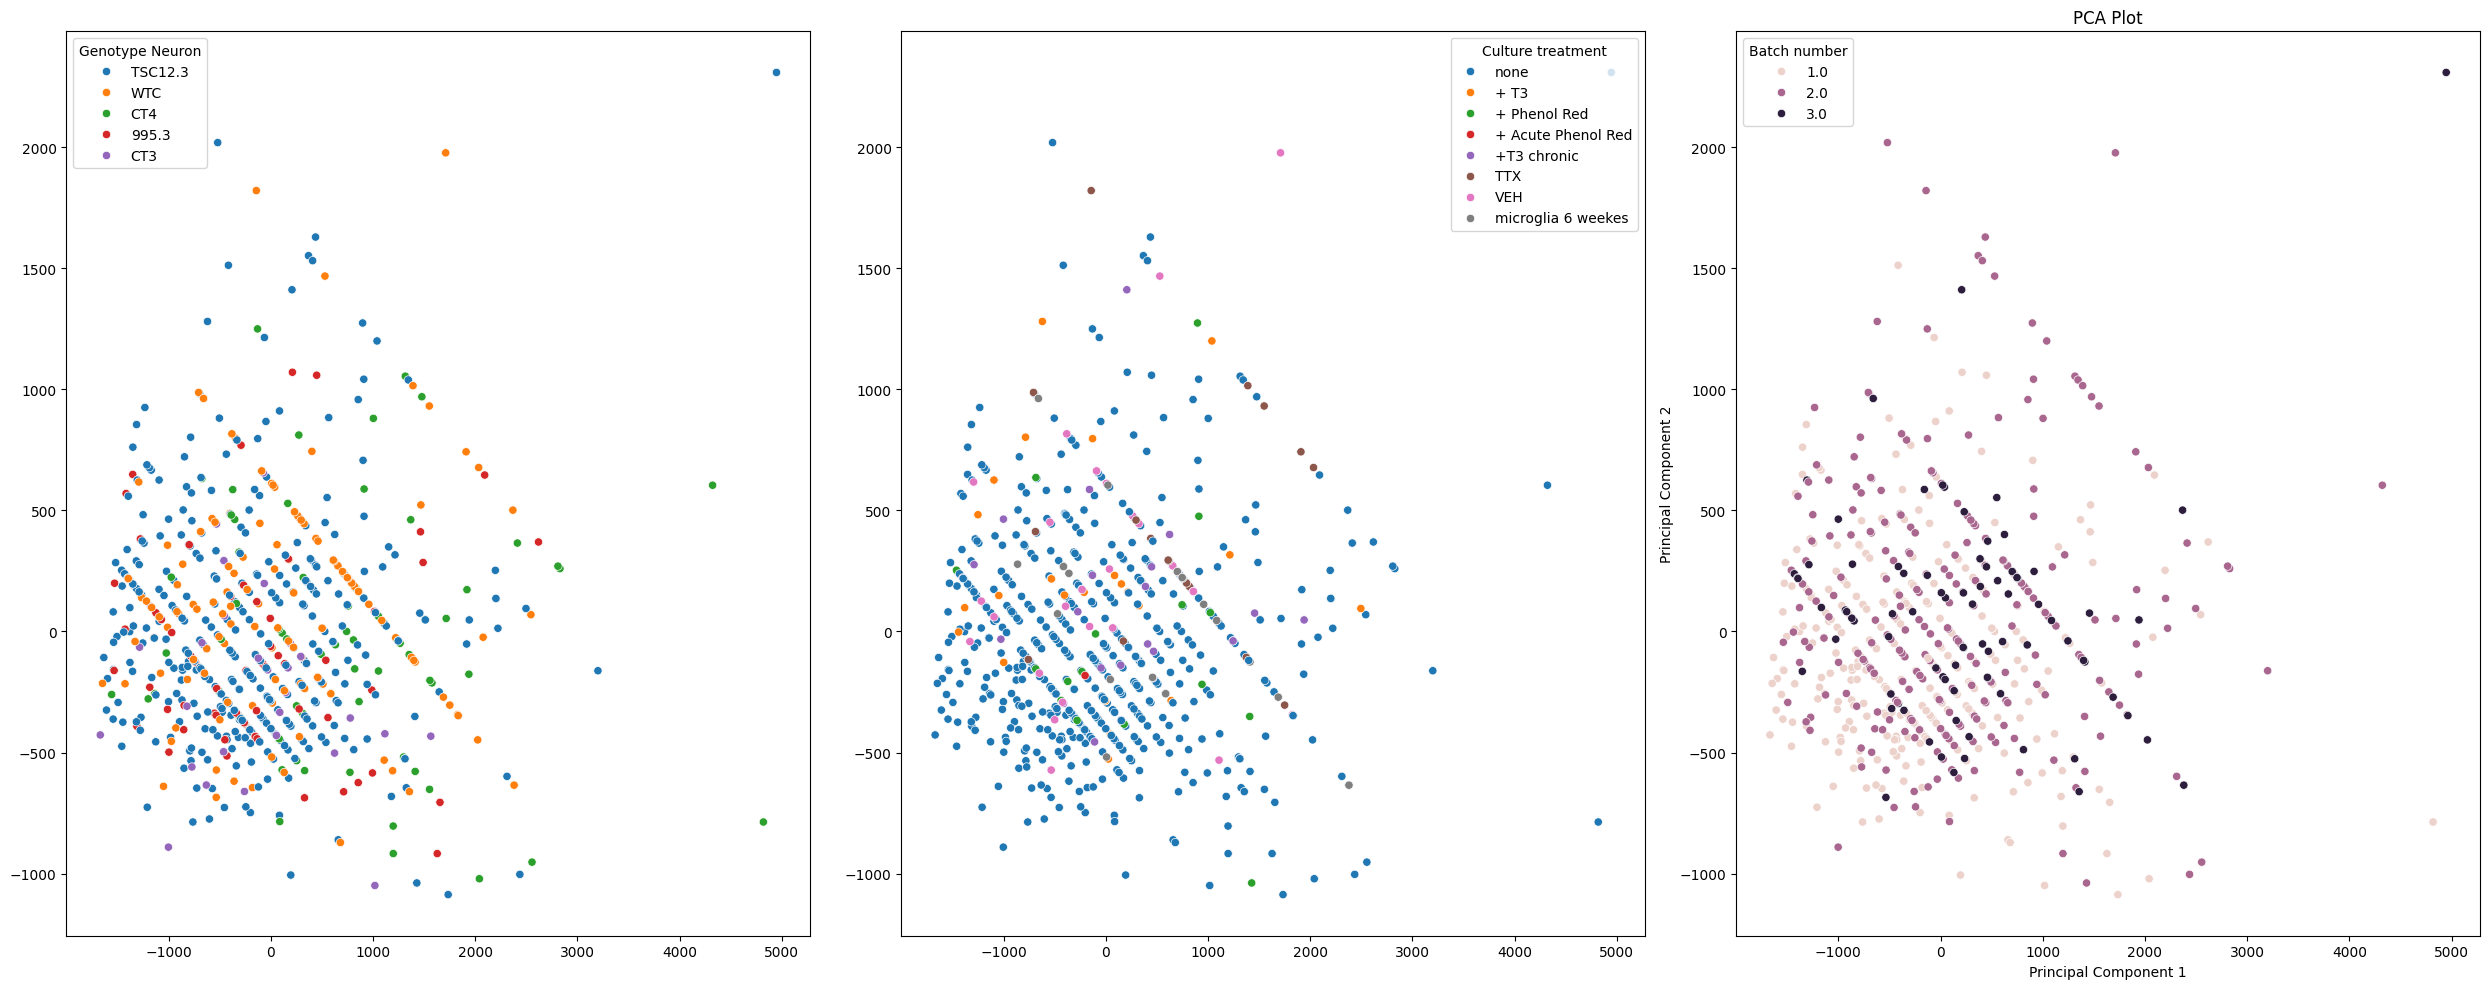

In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


data_extracted_features_imputed_labeled = data_extracted_features_imputed.copy()
object_columns_pca = list(data_extracted_features_impute.select_dtypes(include=['object']).columns)
object_columns_pca.append("Batch number")
# print(object_columns_pca)   
#print(data_extracted_features_imputed_labeled.columns)
data_extracted_features_imputed_labeled.drop(columns=object_columns_pca, inplace=True)    


# # Assuming 'categorical_column' is the name of the column containing categorical variables
# label_encoder = LabelEncoder()
# data_extracted_features_imputed_labeled['Genotype Neuron'] = label_encoder.fit_transform(data_extracted_features_imputed_labeled['Genotype Neuron'].astype(str))  
# print(f"Original values: {label_encoder.classes_}\n Label encoded values: {data_extracted_features_imputed_labeled['Genotype Neuron'].unique()}")
# data_extracted_features_imputed_labeled['Culture treatment'] = label_encoder.fit_transform(data_extracted_features_imputed_labeled['Culture treatment'])  
# print(f"Original values: {label_encoder.classes_}\n Label encoded values: {data_extracted_features_imputed_labeled['Culture treatment'].unique()}")

# Assuming data is your dataset
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_extracted_features_imputed_labeled)

fig, axes = plt.subplots(1, 3, figsize=(25, 10))
axes = axes.flatten()

for i, feature in enumerate(object_columns_pca):
    sns.scatterplot(data=pd.DataFrame(reduced_data), x=reduced_data[:, 0], y=reduced_data[:, 1], hue=data_extracted_features_imputed[feature], ax=axes[i])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Plot')

plt.tight_layout()
plt.show()


## K means clustering

Original values: 995.3 CT3 CT4 TSC12.3 WTC
 Label encoded values: [3 4 2 0 1]
Original values: + Acute Phenol Red + Phenol Red + T3 +T3 chronic TTX VEH microglia 6 weekes none
 Label encoded values: [7 2 1 0 3 4 5 6]
Cluster labels: 
[0 1]
1    445
0    243
Name: Cluster, dtype: int64


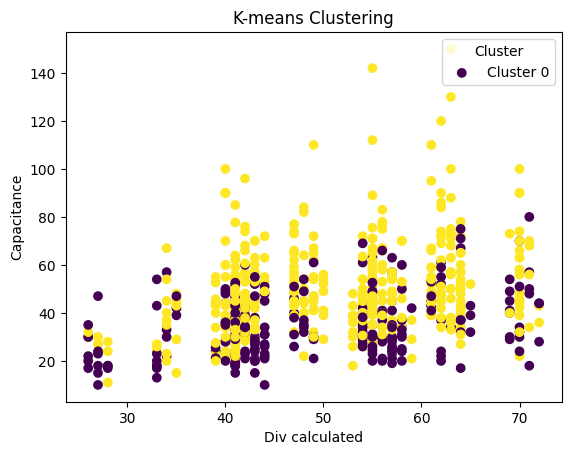

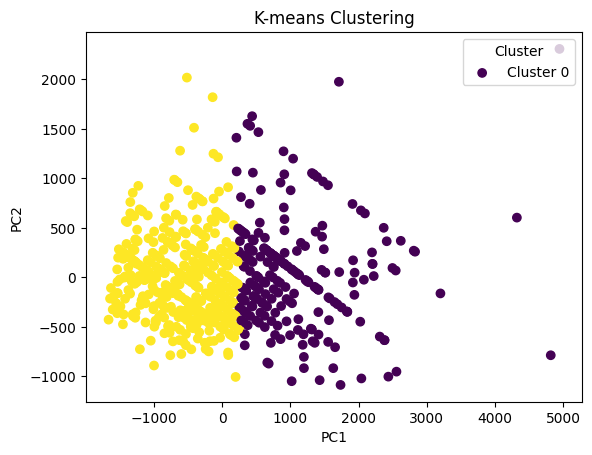

In [54]:
from sklearn.cluster import KMeans


data_extracted_features_imputed_kmeans_labeled = data_extracted_features_imputed.copy() 

label_encoder = LabelEncoder()
data_extracted_features_imputed_kmeans_labeled['Genotype Neuron'] = label_encoder.fit_transform(data_extracted_features_imputed_kmeans_labeled['Genotype Neuron'].astype(str))  
print(f"Original values: {' '.join(label_encoder.classes_)}\n Label encoded values: {data_extracted_features_imputed_kmeans_labeled['Genotype Neuron'].unique()}")
data_extracted_features_imputed_kmeans_labeled['Culture treatment'] = label_encoder.fit_transform(data_extracted_features_imputed_kmeans_labeled['Culture treatment'])  
print(f"Original values: {' '.join(label_encoder.classes_)}\n Label encoded values: {data_extracted_features_imputed_kmeans_labeled['Culture treatment'].unique()}")


kmeans = KMeans(n_clusters=2)

# Fit the KMeans model to the data
kmeans.fit(data_extracted_features_imputed_kmeans_labeled)

cluster_labels = kmeans.labels_
print(f"Cluster labels: \n{np.unique(cluster_labels)}")   

# Add the cluster labels to your DataFrame
data_extracted_features_imputed_kmeans_labeled['Cluster'] = cluster_labels
#print(data_extracted_features_imputed_kmeans_labeled['Cluster'])

# Print the counts of samples in each cluster
print(data_extracted_features_imputed_kmeans_labeled['Cluster'].value_counts())

plt.scatter(x=data_extracted_features_imputed_kmeans_labeled["Div calculated"], y=data_extracted_features_imputed_kmeans_labeled["Capacitance"],  c=cluster_labels)
plt.xlabel('Div calculated')
plt.ylabel('Capacitance')
plt.title('K-means Clustering')
plt.legend(labels=['Cluster 0', 'Cluster 1'], loc='upper right', title='Cluster')
plt.show()

plt.scatter(x=reduced_data[:, 0], y=reduced_data[:, 1],  c=cluster_labels)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering')
plt.legend(labels=['Cluster 0', 'Cluster 1'], loc='upper right', title='Cluster')
plt.show()